# Exploring Ensemble Methods

In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in GraphLab Create. You will:

* Train a boosted ensemble of decision-trees (gradient boosted trees) on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Find the most positive and negative loans using the learned model.
* Explore how the number of trees influences classification performance.

Let's get started!

In [167]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',-1)

# Load LendingClub dataset

In [168]:
loans = pd.read_csv('lending-club-data.csv')

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset. We have done this in previous assignments, so we won't belabor this here.



In [169]:
print len(loans.columns)
print len(loans)
loans.columns

68
122607


Index([u'id', u'member_id', u'loan_amnt', u'funded_amnt', u'funded_amnt_inv',
       u'term', u'int_rate', u'installment', u'grade', u'sub_grade',
       u'emp_title', u'emp_length', u'home_ownership', u'annual_inc',
       u'is_inc_v', u'issue_d', u'loan_status', u'pymnt_plan', u'url', u'desc',
       u'purpose', u'title', u'zip_code', u'addr_state', u'dti',
       u'delinq_2yrs', u'earliest_cr_line', u'inq_last_6mths',
       u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc',
       u'pub_rec', u'revol_bal', u'revol_util', u'total_acc',
       u'initial_list_status', u'out_prncp', u'out_prncp_inv', u'total_pymnt',
       u'total_pymnt_inv', u'total_rec_prncp', u'total_rec_int',
       u'total_rec_late_fee', u'recoveries', u'collection_recovery_fee',
       u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d',
       u'last_credit_pull_d', u'collections_12_mths_ex_med',
       u'mths_since_last_major_derog', u'policy_code', u'not_compliant',
       u'status', u'inactiv

## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [170]:
loans['safe_loans']=loans['bad_loans'].apply(lambda x:+1 if x==0 else -1)
del loans['bad_loans']

In [171]:
loans.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none,safe_loans
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,1.0,1.0,1.0,1,2.3932,20161201T000000,1,1,1,-1


## Selecting features
In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are described in the code comments below. If you are a finance geek, the LendingClub website has a lot more details about these features.

The features we will be using are described in the code comments below:

In [172]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values
Recall from the lectures that one common approach to coping with missing values is to skip observations that contain missing values.

We run the following code to do so:

The below is equivalent to dropna_split() of graphlab 
The first item is the expected output from dropna(), and the second item contains all the rows filtered out by the dropna algorithm.

In [173]:
loans_with_na =loans.columns[loans.isnull().any()]
loans = loans[features + [target]].dropna()
print len(loans.columns)

25


In [174]:
# Count the number of rows with missing data
print type(loans_with_na)
num_rows_with_na = len(loans_with_na)
num_rows = len(loans)
print 'Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows)

<class 'pandas.indexes.base.Index'>
Dropping 21 observations; keeping 122578 


In [175]:
zip(loans.columns,loans.dtypes)

[('grade', dtype('O')),
 ('sub_grade_num', dtype('float64')),
 ('short_emp', dtype('int64')),
 ('emp_length_num', dtype('int64')),
 ('home_ownership', dtype('O')),
 ('dti', dtype('float64')),
 ('purpose', dtype('O')),
 ('payment_inc_ratio', dtype('float64')),
 ('delinq_2yrs', dtype('float64')),
 ('delinq_2yrs_zero', dtype('float64')),
 ('inq_last_6mths', dtype('float64')),
 ('last_delinq_none', dtype('int64')),
 ('last_major_derog_none', dtype('int64')),
 ('open_acc', dtype('float64')),
 ('pub_rec', dtype('float64')),
 ('pub_rec_zero', dtype('float64')),
 ('revol_util', dtype('float64')),
 ('total_rec_late_fee', dtype('float64')),
 ('int_rate', dtype('float64')),
 ('total_rec_int', dtype('float64')),
 ('annual_inc', dtype('float64')),
 ('funded_amnt', dtype('int64')),
 ('funded_amnt_inv', dtype('int64')),
 ('installment', dtype('float64')),
 ('safe_loans', dtype('int64'))]

Fortunately, there are not too many missing values. We are retaining most of the data.

### If you are NOT using SFrame, download the list of indices for the training and validation sets:

module-8-assignment-1-train-idx.json.zip

module-8-assignment-1-validation-idx.json.zip

Then follow the following steps:
	•	Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding. Alternatively, see #7 for implementation hints.
    
	•	Load the JSON files into the lists train_idx and validation_idx.
    
	•	Perform train/validation split using train_idx and validation_idx. In Pandas, for instance:
1


In [176]:
# Apply one-hot encoding to loans. Your tool may have a function for one-hot encoding.


categorical_variables =[]
for feat_name,feat_type in zip(loans.columns,loans.dtypes):
    if feat_type==object: # In pandas dataframe string types shows as object 
        categorical_variables.append(feat_name)

#df['list_from_dict'] = [[x['name'] for x in list_dict] for list_dict in df['list_dicts']]

for feature in categorical_variables:
    loans_one_hot = loans[feature].apply(lambda x:{x:1})
    # the above o/p will give like :  1 {u' 60 months': 1}- so need to convert it like {' 60 months': 1}
    #which is list of dicts
    loans_one_hot_encoded =loans_one_hot.values.tolist() # gives list of dict 
    loans_unpacked = pd.DataFrame(loans_one_hot_encoded) # gives a dataframe 
    
    # Change NaN's to 0's
    for columns in loans_unpacked.columns:
        loans_unpacked[columns]=loans_unpacked[columns].fillna(0)
        loans[columns] = loans_unpacked[columns].values
    del loans[feature]  # removing cols 
    
print len(loans.columns)

45


In [177]:
##Load the JSON files into the lists train_idx and validation_idx.

# 1st read the indexes in a json file 
train_val=pd.read_json('module-8-assignment-1-train-idx.json')
validation_val=pd.read_json('module-8-assignment-1-validation-idx.json')

# list out the values which is ndarray
lst_train =train_val.values.tolist()
lst_validation = validation_val.values.tolist()
# flattening the list of list to single list 
train_idx = [item for sublist in lst_train for item in sublist]
validation_idx = [item  for sublist in lst_validation  for item in sublist]


In [178]:
#Perform train/validation split using train_idx and tvalidation_idx.

train_data = loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]
print len(train_data) , len(validation_data)

37219 9284


In [179]:
print len(train_data.columns)
train_data.columns

45


Index([u'sub_grade_num', u'short_emp', u'emp_length_num', u'dti',
       u'payment_inc_ratio', u'delinq_2yrs', u'delinq_2yrs_zero',
       u'inq_last_6mths', u'last_delinq_none', u'last_major_derog_none',
       u'open_acc', u'pub_rec', u'pub_rec_zero', u'revol_util',
       u'total_rec_late_fee', u'int_rate', u'total_rec_int', u'annual_inc',
       u'funded_amnt', u'funded_amnt_inv', u'installment', u'safe_loans', u'A',
       u'B', u'C', u'D', u'E', u'F', u'G', u'MORTGAGE', u'OTHER', u'OWN',
       u'RENT', u'car', u'credit_card', u'debt_consolidation',
       u'home_improvement', u'house', u'major_purchase', u'medical', u'moving',
       u'other', u'small_business', u'vacation', u'wedding'],
      dtype='object')

## Make sure the classes are balanced

We saw in an earlier assignment that this dataset is also imbalanced. We will undersample the larger class (safe loans) in order to balance out our dataset. We used seed=1 to make sure everyone gets the same results.

In [180]:

'''
# This is not performed without Graphlab 
safe_loans_raw =loans[loans[target]==1]
risky_loans_raw = loans[loans[target]==-1]

# Undersample the safe loans.
percentage = len(risky_loans_raw) / float(len(safe_loans_raw))
print (percentage)

safe_loans = safe_loans_raw.sample(frac=percentage,replace=True)
risky_loans = risky_loans_raw

# Append the risky_loans with the downsampled version of safe_loans
loans_data =risky_loans.append(safe_loans)

print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)
'''


'\n# This is not performed without Graphlab \nsafe_loans_raw =loans[loans[target]==1]\nrisky_loans_raw = loans[loans[target]==-1]\n\n# Undersample the safe loans.\npercentage = len(risky_loans_raw) / float(len(safe_loans_raw))\nprint (percentage)\n\nsafe_loans = safe_loans_raw.sample(frac=percentage,replace=True)\nrisky_loans = risky_loans_raw\n\n# Append the risky_loans with the downsampled version of safe_loans\nloans_data =risky_loans.append(safe_loans)\n\nprint "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))\nprint "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))\nprint "Total number of loans in our new dataset :", len(loans_data)\n'

## Gradient boosted tree classifier

 Now, let's use the built-in scikit learn gradient boosting classifier **(sklearn.ensemble.GradientBoostingClassifier)** to create a gradient boosted classifier on the training data. You will need to import sklearn, sklearn.ensemble, and numpy.
 
 
You will have to first convert the SFrame into a numpy data matrix. See the API for more information. You will also have to extract the label column. 

Make sure to set max_depth=6 and n_estimators=5.


In [181]:
 import sklearn,sklearn.ensemble

In [182]:
print type(train_data[target])
print type(train_data[target].as_matrix())
print len(train_data.columns)

<class 'pandas.core.series.Series'>
<type 'numpy.ndarray'>
45


In [183]:
train_data.as_matrix(columns=features)
train_data.dtypes

sub_grade_num            float64
short_emp                int64  
emp_length_num           int64  
dti                      float64
payment_inc_ratio        float64
delinq_2yrs              float64
delinq_2yrs_zero         float64
inq_last_6mths           float64
last_delinq_none         int64  
last_major_derog_none    int64  
open_acc                 float64
pub_rec                  float64
pub_rec_zero             float64
revol_util               float64
total_rec_late_fee       float64
int_rate                 float64
total_rec_int            float64
annual_inc               float64
funded_amnt              int64  
funded_amnt_inv          int64  
installment              float64
safe_loans               int64  
A                        float64
B                        float64
C                        float64
D                        float64
E                        float64
F                        float64
G                        float64
MORTGAGE                 float64
OTHER     

In [184]:
target

'safe_loans'

In [200]:
model_5 = sklearn.ensemble.GradientBoostingClassifier(max_depth=6,n_estimators=5)
model_5.fit(train_data.drop('safe_loans',1).as_matrix(),train_data[target])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples from the validation set. 
We will do the following:
    
	•	Predict whether or not a loan is likely to default.
    
	•	Predict the probability with which the loan is likely to default.
    
#10. First, let's grab 2 positive examples and 2 negative examples.  


In [201]:
validation_safe_loans = validation_data[validation_data[target]==1]
validation_risky_loans = validation_data[validation_data[target]==-1]

sample_validation_data_risky= validation_risky_loans[0:2]
sample_validation_data_safe= validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,small_business,vacation,wedding
22,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
41,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
sample_validation_data_risky

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,small_business,vacation,wedding
24,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
41,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
sample_validation_data_safe

,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,last_major_derog_none,...,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,small_business,vacation,wedding
22,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
sample_validation_data[target]

22    1
26    1
24   -1
41   -1
Name: safe_loans, dtype: int64

**For each row in the sample_validation_data**, 
write code to make model_5 predict whether or not the loan is classified as a safe loan. 

(Hint: if you are using scikit-learn, you can use the .predict() method)
 

In [190]:
model_5.classes_ , model_5.get_params  

(array([-1,  1]),
 <bound method GradientBoostingClassifier.get_params of GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
               max_depth=6, max_features=None, max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=5, presort='auto',
               random_state=None, subsample=1.0, verbose=0,
               warm_start=False)>)

In [202]:
model_5.predict(sample_validation_data.drop('safe_loans',1).as_matrix())

array([ 1,  1, -1,  1])

**Quiz question:** What percentage of the predictions on sample_validation_data did model_5 get correct?


*** predicts all correct . since 1st 2 of sample_validation_data refers to safe and rest 2 are risky . and predictions 
are same too ,i.e 100%***

## Prediction Probabilities

#12. For each row in the sample_validation_data, what is the probability (according model_5) of a loan 
#being classified as safe? (Hint: if you are using scikit-learn, you can use the .predict_proba() method)

predict_proba() method Returns 
array of shape = [n_samples]

The class probabilities of the input samples. The order of the classes corresponds to that in the attribute classes_.

In [216]:
model_5.predict_proba(sample_validation_data.drop('safe_loans',axis=1)) # axis =1 refers to col

array([[ 0.41642331,  0.58357669],
       [ 0.46949689,  0.53050311],
       [ 0.53807792,  0.46192208],
       [ 0.39591639,  0.60408361]])

**Quiz Question:**
Which loan has the highest probability of being classified as a safe loan?


In [193]:
#sample_validation_data[target] - gives +1,+1,-1,-1 i.e safe,safe,risky,risky 
#predict_proba - gives 2 values in each row i.e prob for each class i.e 0.0.41642331 -> prob for -1 ,
#0.58357669 -> prob for +1 ( this is in ascending order of classes)
#since it classifies all correctly with correct prob for +1 = 0.58357669 and -1 = 0.41642331 , but 
#highest is 1st  data points i.e sub_grade 0.2  . Check the options too

**Checkpoint:** Can you verify that for all the predictions with probability >= 0.5, the model predicted the label +1?


No,for 1st 2 having prob > 0.5 model predicted +1 but for last 2 its -1. 

## Evaluating the model on the validation data

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

**Hint**: if you are using scikit-learn, you can use the .score() method)

In [215]:
model_5.score(validation_data.drop('safe_loans',axis=1).as_matrix(),validation_data[target])

0.66146057733735464

**Quiz Question**: What is the number of false positives on the validation_data?

In [218]:
actual_values=validation_data[target]
predicted_values =model_5.predict(validation_data.drop('safe_loans',axis=1).as_matrix())

# false positives means where you get a positive result +1 and it is false(i.e actual is -1)i.e you should have got -1

In [219]:
print len(actual_values)  
print len(predicted_values)
# actual_values - is pandas Series so convert it to np.array 
np.array(actual_values)

9284
9284


array([-1, -1, -1, ...,  1,  1,  1])

In [220]:
num_false_positive=0
actual_values_arr =np.array(actual_values)
for i in xrange(len(predicted_values)):
    if (predicted_values[i]==1 and actual_values_arr[i] ==-1):
        num_false_positive=num_false_positive+1
        
print num_false_positive    
# these results are wrong becoz score is 1 i.e it predicts all correctly 

1652


Calculate the number of **false negatives** made by the model.

In [221]:
num_false_negatives=0
for i in xrange(len(predicted_values)):
    if (predicted_values[i]==-1 and actual_values_arr[i] ==1):
        num_false_negatives=num_false_negatives+1
        
print num_false_negatives    
# these results are wrong becoz score is 1 i.e it predicts all correctly 

1491


## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.

**Quiz Question**: Using the same costs of the false positives and false negatives, what is the cost of the mistakes made by the boosted tree model (**model_5**) as evaluated on the **validation_set**?

In [222]:
cost = 10000 * 1491   + 20000 * 1652
print cost

47950000


## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

Start here with **Step 1** & **Step 2**. Make predictions using **model_5** for examples in the **validation_data**. 

In [226]:
validation_data['predictions']=model_5.predict_proba(validation_data.drop('safe_loans',axis=1))[:,1] 
# doubt is why it is considered only the 1st col here .

/Users/pbishwal/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Now, we are ready to go to **Step 3**. You can now use the `prediction` column to sort the loans in **validation_data** (in descending order) by prediction probability. Find the top 5 loans with the highest probability of being predicted as a **safe loan**.

In [231]:
validation_data[['A','B','C','D','predictions']].sort('predictions',ascending=False).head(5)

/Users/pbishwal/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,A,B,C,D,predictions
8021,1.0,0.0,0.0,0.0,0.673059
34261,1.0,0.0,0.0,0.0,0.661468
81153,1.0,0.0,0.0,0.0,0.661468
15486,1.0,0.0,0.0,0.0,0.661468
99626,1.0,0.0,0.0,0.0,0.661468


** Quiz Question**: What grades are the top 5 loans?

#top 5 belongs to belongs to grade A 

Let us repeat this excercise to find the top 5 loans (in the **validation_data**) with the **lowest probability** of being predicted as a **safe loan**:

In [232]:
validation_data[['A','B','C','D','predictions']].sort('predictions',ascending=True).head(5)

/Users/pbishwal/anaconda/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,A,B,C,D,predictions
84508,0.0,0.0,1.0,0.0,0.307334
58794,0.0,0.0,1.0,0.0,0.307334
27502,0.0,0.0,1.0,0.0,0.312806
101746,0.0,0.0,0.0,1.0,0.315973
84921,0.0,0.0,1.0,0.0,0.315973


In [233]:
#['C', 'C', 'C', 'D', 'C'  # this is different from graphlab may be due to data mismatch

## Effect of adding more trees

In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees. We use the max_iterations parameter in the boosted tree module.


Train models with 10, 50, 100, 200, and 500 trees. 

Use the **n_estimators parameter** to control the number of trees. Remember to keep **max_depth = 6**.

Call these models model_10, model_50, model_100, model_200, and model_500, respectively. This may take a few minutes to run.


In [236]:
model_10 = sklearn.ensemble.GradientBoostingClassifier(max_depth=6,n_estimators=10)
model_10.fit(train_data.drop('safe_loans',axis=1).as_matrix(),train_data[target])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [237]:
model_50 = sklearn.ensemble.GradientBoostingClassifier(max_depth=6,n_estimators=50)
model_50.fit(train_data.drop('safe_loans',axis=1).as_matrix(),train_data[target])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [238]:
model_100 = sklearn.ensemble.GradientBoostingClassifier(max_depth=6,n_estimators=100)
model_100.fit(train_data.drop('safe_loans',axis=1).as_matrix(),train_data[target])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [239]:
model_200 = sklearn.ensemble.GradientBoostingClassifier(max_depth=6,n_estimators=200)
model_200.fit(train_data.drop('safe_loans',1).as_matrix(),train_data[target])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [240]:
model_500 = sklearn.ensemble.GradientBoostingClassifier(max_depth=6,n_estimators=500)
model_500.fit(train_data.drop('safe_loans',axis=1).as_matrix(),train_data[target])

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=6, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Compare accuracy on entire validation set


Now we will compare the predicitve accuracy of our models on the validation set.

Evaluate the accuracy of the 10, 50, 100, 200, and 500 tree models on the validation_data.


In [242]:
model_10.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])

0.66544592847910389

In [243]:
model_50.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])

0.68504954760878933

In [244]:
model_100.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])

0.68989659629470057

In [245]:
model_200.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])

0.68601895734597151

In [246]:
model_500.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])

0.68978888410168027

**Quiz Question:** Which model has the **best** accuracy on the **validation_data**?

**Quiz Question:** Is it always true that the model with the most trees will perform best on test data?

In [247]:
#out of all thes model_100 has best accuracy on validation data 
#NO it is not always true that the model with the most trees will perform best on test data

## Plot the training and validation error vs. number of trees

Recall from the lecture that the classification error is defined as
​
$$
\mbox{classification error} = 1 - \mbox{accuracy} 
$$
​
In this section, we will plot the **training and validation errors versus the number of trees** to get a sense of how these models are performing. We will compare the 10, 50, 100, 200, and 500 tree models. You will need [matplotlib](http://matplotlib.org/downloads.html) in order to visualize the plots. 
​
First, make sure this block of code runs on your computer.


In [248]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In order to plot the classification errors (on the **train_data** and **validation_data**) versus the number of trees, we will need lists of these accuracies, which we get by applying the method `.evaluate`. 

**Steps to follow:**

* **Step 1:** Calculate the classification error for model on the training data (**train_data**).
* **Step 2:** Store the training errors into a list (called `training_errors`) that looks like this:
```
[train_err_10, train_err_50, ..., train_err_500]
```
* **Step 3:** Calculate the classification error of each model on the validation data (**validation_data**).
* **Step 4:** Store the validation classification error into a list (called `validation_errors`) that looks like this:
```
[validation_err_10, validation_err_50, ..., validation_err_500]
```
Once that has been completed, the rest of the code should be able to evaluate correctly and generate the plot.


Let us start with **Step 1**. Write code to compute the classification error on the **train_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [249]:
train_err_10 = 1-model_10.score(train_data.drop(['safe_loans'],axis=1),train_data[target])
train_err_50 = 1-model_50.score(train_data.drop(['safe_loans'],axis=1),train_data[target])
train_err_100 = 1-model_100.score(train_data.drop(['safe_loans'],axis=1),train_data[target])
train_err_200 = 1-model_200.score(train_data.drop(['safe_loans'],axis=1),train_data[target])
train_err_500 = 1-model_500.score(train_data.drop(['safe_loans'],axis=1),train_data[target])

Now, let us run **Step 2**. Save the training errors into a list called **training_errors**

In [250]:
training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]
training_errors

[0.32891802573954165,
 0.28259759800102102,
 0.25379510465085042,
 0.21271393643031788,
 0.13681184341331043]

Now, onto **Step 3**. Write code to compute the classification error on the **validation_data** for models **model_10**, **model_50**, **model_100**, **model_200**, and **model_500**.

In [251]:
validation_err_10=  1-model_10.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])
validation_err_50=  1-model_50.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])
validation_err_100= 1-model_100.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])
validation_err_200= 1-model_200.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])
validation_err_500= 1-model_500.score(validation_data.drop(['safe_loans','predictions'],axis=1),validation_data[target])

Now, let us run **Step 4**. Save the training errors into a list called **validation_errors**

In [252]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]
validation_errors

[0.33455407152089611,
 0.31495045239121067,
 0.31010340370529943,
 0.31398104265402849,
 0.31021111589831973]

Now, we will plot the **training_errors** and **validation_errors** versus the number of trees. We will compare the 10, 50, 100, 200, and 500 tree models. We provide some plotting code to visualize the plots within this notebook. 

Run the following code to visualize the plots.

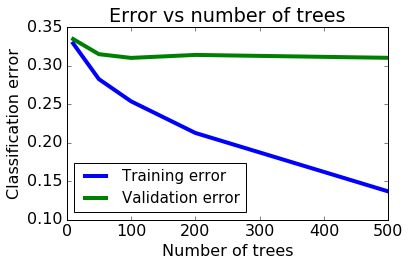

In [254]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')


**Quiz Question**: Does the training error reduce as the number of trees increases?

**Quiz Question**: Is it always true that the validation error will reduce as the number of trees increases?

In [255]:
# Yes training error reduces as number of trees increases 
# No it is not always true that validation error reduce as number of trees inc as we can we it goes 500 it again inc's